# Preliminaries

## Load

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import sklearn as skl
import scipy as sp
import scipy.cluster.hierarchy
from sklearn import datasets

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from skimage import color
from colorsys import rgb_to_hsv

import sys
sys.path.append('/home/andy/Documents/Research/pnri/Helpers')
sys.path.append('/home/andy/Documents/Research/Minimax_Linkage/cpp_code/')

import importlib
pcl = importlib.import_module('protoclust')
pd = importlib.import_module('pydistance')
dm = importlib.import_module('distance_matrix')
cpcl = importlib.import_module('c_protoclust')
cplt = importlib.import_module('colonyplotting')
ioh = importlib.import_module('iohelp')

## Reload 

In [3]:
pcl = importlib.reload(pcl)
pd = importlib.reload(pd)
dm = importlib.reload(dm)
cpcl = importlib.reload(cpcl)
cplt = importlib.reload(cplt)
ioh = importlib.reload(ioh)

## Utilities

In [4]:
def labelXYZ(ax, xlabel, ylabel, zlabel=None, params={}):
    ax.set_xlabel(xlabel, **params)
    ax.set_ylabel(ylabel, **params)
    if zlabel:
        ax.set_zlabel(zlabel, **params)
    return ax

# https://joernhees.de/blog/
def fancy_dendrogram(ax, *args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sp.cluster.hierarchy.dendrogram(*args, **kwargs)

    if kwargs.get('truncate_mode', False):
        trunc_where = 'p={}'.format(kwargs.get('p', None))
    
    if not kwargs.get('no_plot', False):
        ax.set_title('Hierarchical Clustering Dendrogram (truncated {})'.format(trunc_where))
#         ax.set_xlabel('sample index or (cluster size)')
        ax.set_ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                ax.plot(x, y, 'o', c=c)
        if max_d:
            ax.axhline(y=max_d, c='k', ls='--')
    return ddata

# Example: Gaussians in 2D

In [5]:
def draw_n(n, params):
    return np.random.multivariate_normal(params['mean'], params['cov'], n).T

<IPython.core.display.Javascript object>


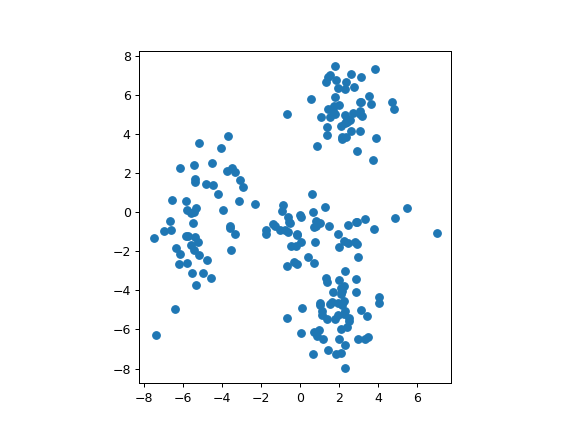

In [92]:
fig, ax = plt.subplots(1)
np.random.seed(3)
data = np.array([]).reshape(-1,2)
data = np.vstack([data, draw_n(50, {'mean': [-5, 0], 'cov': [[1, 1], [1, 5]]}).T])
data = np.vstack([data, draw_n(50, {'mean': [1, -1], 'cov': [[5, 0], [0, 1]]}).T])
data = np.vstack([data, draw_n(50, {'mean': [2, 5], 'cov': [[1, 0], [0, 1]]}).T])
data = np.vstack([data, draw_n(50, {'mean': [2, -5], 'cov': [[1, 0], [0, 1]]}).T])
ax.scatter(data[:,0], data[:,1])
ax.set_aspect('equal')

In [103]:
dd = pd.PyDistance(data, True, True)
dda = dd.asarray()

<IPython.core.display.Javascript object>


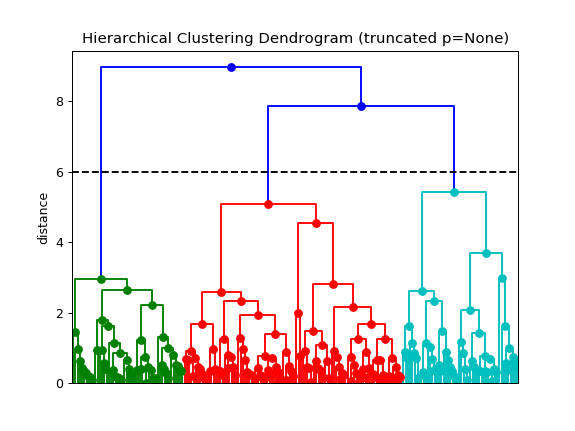

3


<IPython.core.display.Javascript object>


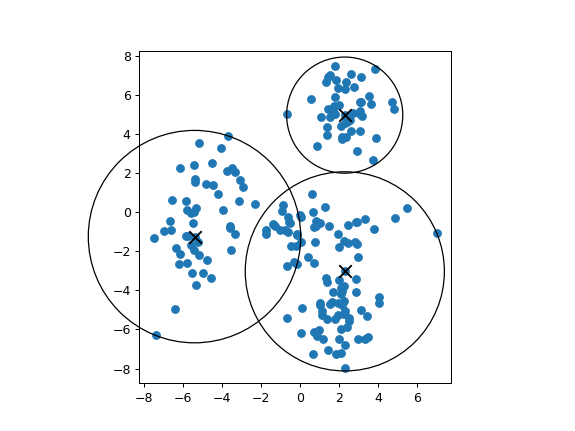

In [105]:
Z, clustering_data = cpcl.protoclust(dda, verbose=True, notebook=True)
clustering, clustering_centers, clustering_distances = [np.array(i) for i in clustering_data]

cut_height = 6

fig,ax  = plt.subplots(1)
fancy_dendrogram(ax, Z, truncate_mode='none', distance_sort=True, max_d=cut_height);
ax.set_xticks([])

T = sp.cluster.hierarchy.fcluster(Z, cut_height, criterion='distance')
indices,_ = sp.cluster.hierarchy.leaders(Z,T)
print(len(indices))
colors, cnorm = [mpl.cm.get_cmap('tab10'), len(indices)]

fig, ax = plt.subplots(1)
ax.scatter(data[:,0], data[:,1])
centers = data[clustering_centers[indices]]
ax.scatter(*centers.T, c='k', marker='x', s=100)
for xy, r in zip(centers, clustering_distances[indices]):
    ax.add_artist(mpl.patches.Circle(xy, radius=r, fill=False, clip_on=False))

ax.set_aspect('equal')

# Example: Faces

In [106]:
faces = skl.datasets.fetch_olivetti_faces()
X = faces.data
n,d = X.shape # d = 64x64
Y = faces.target

U,S,Vt = np.linalg.svd(X - np.mean(X, axis=0))

n,d

(400, 4096)

## Inspect SVD

<IPython.core.display.Javascript object>


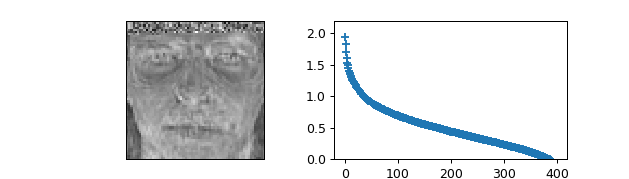

(0, 2.2)

In [107]:
fig, ax = plt.subplots(1,2, figsize=[7,2])
fig.subplots_adjust(wspace=0.1)

ax[0].imshow(Vt[:,0].reshape(64,64), cmap='gray')
cplt.clean_ax(ax[0])

ax[1].scatter(list(range(len(S))), np.log10(S), marker='+')
ax[1].set_ylim([0,2.2])

<IPython.core.display.Javascript object>


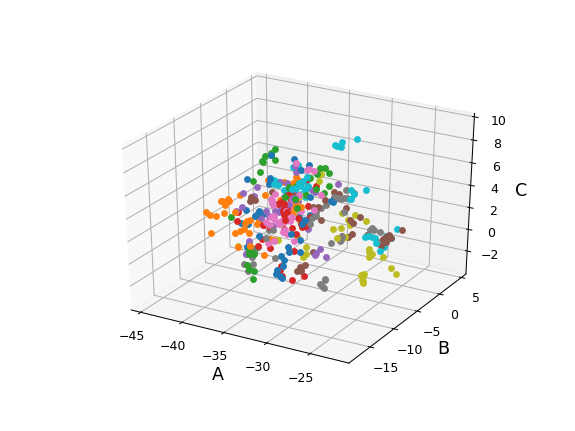

In [7]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
colors, cnorm = [mpl.cm.get_cmap('tab10'), np.max(Y)]
for i,j,k,c in zip(pcX[:,0], pcX[:,1], pcX[:,2],Y):
    ax.scatter(i,j,k,color=colors(c/cnorm))
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

## Protoclust

In [112]:
dd1 = pd.PyDistance(X)
dd1a = dd1.asarray()


7


<IPython.core.display.Javascript object>


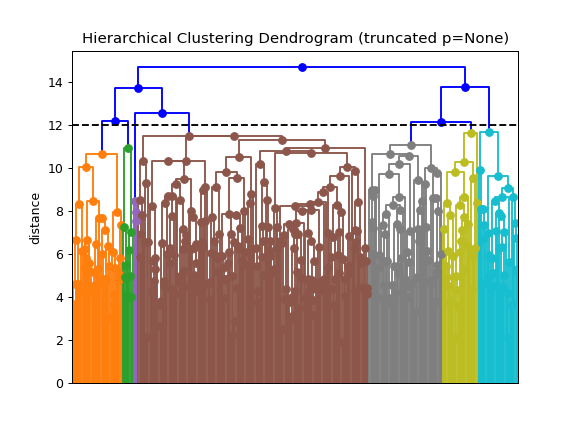

[]

In [188]:
Z, clustering_data = cpcl.protoclust(dd2a, verbose=True, notebook=True)
clustering, clustering_centers, clustering_distances = [np.array(i) for i in clustering_data]

cut_height = 12

T = sp.cluster.hierarchy.fcluster(Z, cut_height, criterion='distance')
indices,_ = sp.cluster.hierarchy.leaders(Z,T)
print(len(indices))
colors, cnorm = [mpl.cm.get_cmap('tab10'), len(indices)]

sp.cluster.hierarchy.set_link_color_palette([mpl.colors.to_hex(colors(k/cnorm)) for k in np.unique(T)])
fig,ax  = plt.subplots(1)
fancy_dendrogram(ax, Z, truncate_mode='none', max_d=cut_height);
ax.set_xticks([])


<IPython.core.display.Javascript object>


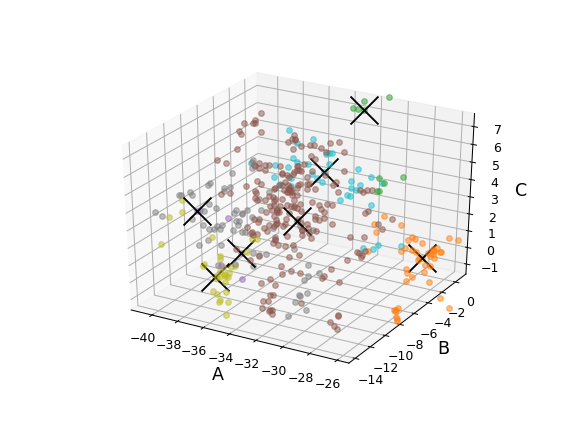

In [189]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
for index, row in enumerate(pcX):
    c='gray'
    x1,x2,x3 = row
    ax.scatter(x1,x2,x3,color=colors(T[index]/cnorm), alpha=0.5)

for center in clustering_centers[indices]:
    x1,x2,x3 = pcX[center,:3]
    ax.scatter(x1,x2,x3, color='k', s=500, marker='x')
             
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

<IPython.core.display.Javascript object>


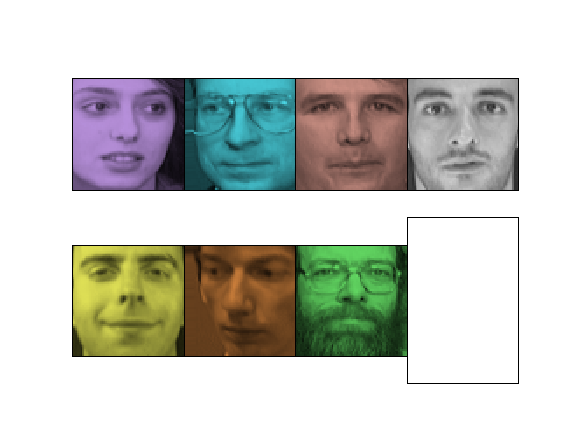

In [190]:
fig, ax = plt.subplots(2,4)
fig.subplots_adjust(wspace=0, hspace=0)
for i,row in enumerate(np.sort(clustering_centers[indices])):
    if len(ax.flatten()) == i:
        break
    im = X[row].reshape(64,64)
    im = color.gray2rgb(X[row].reshape(64,64))
    c_hsv = rgb_to_hsv(*colors(T[row]/cnorm)[:-1])
    im = cplt.colorize(im, c_hsv[0], .75*c_hsv[1])
    ax.flatten()[i].imshow(im, cmap='gray')
[cplt.clean_ax(iax) for iax in ax.flat];

# Example: Words

In [5]:
from scipy.io import loadmat

In [6]:
words = loadmat('Playground/grolier15276.mat')
X = words['grolier'].toarray()
n,d = X.shape

In [7]:
n,d

(15276, 30991)

In [175]:
def pairwise_dissimilarity(x,y):
    return 1 - np.sum(x*y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [8]:
dd3 = pd.PyDistance(X, True, True)

In [7]:
dd3a = dd3.asarray()

In [8]:
Z, clustering_data = cpcl.protoclust(dd3a, verbose=True, notebook=True)
clustering, clustering_centers, clustering_distances = [np.array(i) for i in clustering_data]

KeyboardInterrupt: 